In [122]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, Input, GlobalMaxPooling1D, Dense
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers.merge import Concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score
import tensorflow as tf
from keras.layers import Activation, Embedding, Flatten, Dropout, Conv1D

from numpy import array
from numpy import asarray
from numpy import zeros
import pandas as pd
import numpy as np
import re

embeddings_dictionary = dict()

In [123]:
df_train=pd.read_csv("dataset1.csv")
filter = df_train["text"] != ""
df_train = df_train[filter]
df_train = df_train.dropna()
df_train_labels = df_train[["anger", "fear", "joy", "love", "sadness", "surprise", "thankfulness",
                            "disgust", "guilt"]]

In [124]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [125]:
X = []
sentences = list(df_train["text"])
for sen in sentences:
    X.append(preprocess_text(sen))

y = df_train_labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [126]:
# convert textual inputs to embedded vectors

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

## CNN with WordEmbedding
Convolutional Neural Networks recognize local patterns in a sequence by processing multiple words at the same time

In [127]:
filter_length = 300
model = Sequential()
model.add(Embedding(vocab_size, 20, input_length=maxlen))
model.add(Conv1D(filter_length, 3, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPool1D())
model.add(Dense(9))
model.add(Activation('sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

In [128]:
print(model.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 200, 20)           549420    
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 198, 300)          18300     
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 300)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 9)                 2709      
_________________________________________________________________
activation_7 (Activation)    (None, 9)                 0         
Total params: 570,429
Trainable params: 570,429
Non-trainable params: 0
_________________________________________________________________
None


In [129]:
history = model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=True, validation_data=(X_test, y_test))

Epoch 1/5
125/125 [==============================] - 13s 95ms/step - loss: 0.3793 - auc_9: 0.6964 - val_loss: 0.2892 - val_auc_9: 0.8519
Epoch 2/5
125/125 [==============================] - 12s 93ms/step - loss: 0.2465 - auc_9: 0.8884 - val_loss: 0.2234 - val_auc_9: 0.9087
Epoch 3/5
125/125 [==============================] - 13s 100ms/step - loss: 0.1981 - auc_9: 0.9291 - val_loss: 0.2066 - val_auc_9: 0.9231
Epoch 4/5
125/125 [==============================] - 13s 101ms/step - loss: 0.1722 - auc_9: 0.9476 - val_loss: 0.1985 - val_auc_9: 0.9307
Epoch 5/5
125/125 [==============================] - 13s 100ms/step - loss: 0.1525 - auc_9: 0.9590 - val_loss: 0.1973 - val_auc_9: 0.9337


In [130]:
y_pred = model.predict(X_test)

thresholds=[0.1,0.2,0.25,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for val in thresholds:
    pred=y_pred.copy()
  
    pred[pred>=val]=1
    pred[pred<val]=0
  
    precision = precision_score(y_test, pred, average='micro')
    recall = recall_score(y_test, pred, average='micro')
    f1 = f1_score(y_test, pred, average='micro')
   
    print("Threshold: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(val, precision, recall, f1))

Threshold: 0.1000, Precision: 0.4634, Recall: 0.8567, F1-measure: 0.6015
Threshold: 0.2000, Precision: 0.5746, Recall: 0.7681, F1-measure: 0.6574
Threshold: 0.2500, Precision: 0.6176, Recall: 0.7323, F1-measure: 0.6701
Threshold: 0.3000, Precision: 0.6537, Recall: 0.6998, F1-measure: 0.6760
Threshold: 0.4000, Precision: 0.7120, Recall: 0.6438, F1-measure: 0.6762
Threshold: 0.5000, Precision: 0.7685, Recall: 0.5888, F1-measure: 0.6667
Threshold: 0.6000, Precision: 0.8095, Recall: 0.5394, F1-measure: 0.6474
Threshold: 0.7000, Precision: 0.8509, Recall: 0.4858, F1-measure: 0.6185
Threshold: 0.8000, Precision: 0.8917, Recall: 0.4205, F1-measure: 0.5715
Threshold: 0.9000, Precision: 0.9220, Recall: 0.3310, F1-measure: 0.4872


In [137]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

125/125 [==============================] - 1s 7ms/step - loss: 0.1973 - auc_9: 0.9337
Test Score: 0.197306826710701
Test Accuracy: 0.9337053298950195


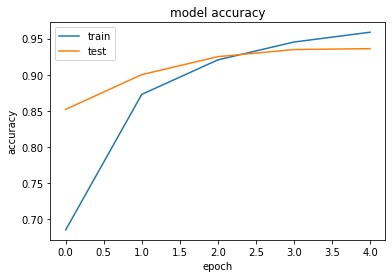

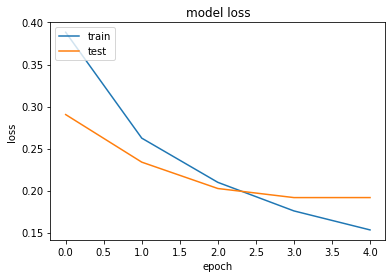

In [95]:
import matplotlib.pyplot as plt
plt.plot(history.history['auc_7'])
plt.plot(history.history['val_auc_7'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## LSTM with GloVe WordEmbedding

In [96]:
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
             

In [97]:
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)

dense_layer_1 = Dense(9, activation='sigmoid')(LSTM_Layer_1)

LSTM_model = Model(inputs=deep_inputs, outputs=dense_layer_1)

LSTM_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.AUC()])

In [98]:
print(LSTM_model.summary())

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding_12 (Embedding)     (None, 200, 100)          2747100   
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_27 (Dense)             (None, 9)                 1161      
Total params: 2,865,509
Trainable params: 118,409
Non-trainable params: 2,747,100
_________________________________________________________________
None


In [99]:
history_LTSM = LSTM_model.fit(X_train, y_train, batch_size=128, epochs=2, verbose=1, validation_split=0.2)

Epoch 1/2
100/100 [==============================] - 59s 569ms/step - loss: 0.3433 - auc_8: 0.7474 - val_loss: 0.3009 - val_auc_8: 0.8119
Epoch 2/2
100/100 [==============================] - 51s 513ms/step - loss: 0.3019 - auc_8: 0.8109 - val_loss: 0.3008 - val_auc_8: 0.8143


In [100]:
score = LSTM_model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

125/125 [==============================] - 10s 77ms/step - loss: 0.3075 - auc_8: 0.8061
Test Score: 0.3074973225593567
Test Accuracy: 0.8061087131500244


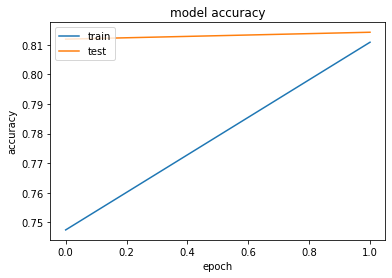

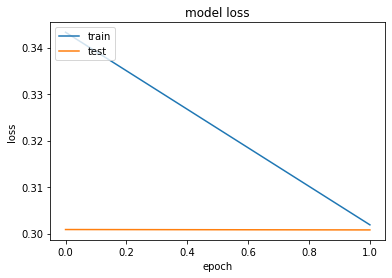

In [102]:
plt.plot(history_LTSM.history['auc_8'])
plt.plot(history_LTSM.history['val_auc_8'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history_LTSM.history['loss'])
plt.plot(history_LTSM.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()